In [1]:
# Import dependencies
import random
import numpy as np
import torch
import torch.nn as nn

# You can find Alfredo's plotting code in plot_lib.py in this directory .
# Download it along with this assignment and keep it in the same directory.
from plot_lib import set_default, show_scatterplot, plot_bases

from matplotlib.pyplot import plot, title, axis

In [198]:
# Set up your device 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print("Device:","cuda:0" if cuda else "cpu")

Device: cuda:0


In [6]:
# Set up random seed to 1008. Do not change the random seed.
# Yes, these are all necessary when you run experiments!
seed = 1008 # But I want to use 42! :(
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# 1. Full, slice, fill
Write a function `warm_up` that returns the 2D tensor with integers below. **Do not use any loops**.

```
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
```


Hint: Use `torch.full`, `torch.fill_`, and the slicing operator.

#### Solution:

In [77]:
def warm_up():
    data = torch.full((13, 13), 1, dtype=torch.int)
    # Rows of twos (starting from 1, every 5)
    data[1::5,:].fill_(2)
    # Cols of twos (starting from 1, every 5)
    data[:,1::5].fill_(2)
    # Squares of trees (dont know how to do better ):
    data[3:5,  3::5].fill_(3)
    data[3:5,  4::5].fill_(3)
    data[8:10, 3::5].fill_(3)
    data[8:10, 4::5].fill_(3)
    return data

# Uncomment line below once you implement this function. 
print(warm_up())

tensor([[1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1]], dtype=torch.int32)


# 2. To Loop or not to loop

The motivation for the following three sub-questions is to get you to think critically about how to write your deep learning code. These sorts of choices can make the difference between tractable and intractable model training.

## 2.1. `mul_row_loop`
Write a function `mul_row_loop`, using python loops with simple indexing but no advanced indexing/slicing, that receives a 2D tensor as input and returns a tensor of same size that is 
- equal to the input on the first row
- 2 times the input's second row on the second row
- 3 times the input's third row on the third row
- etc..

For instance:
```
>>> t = torch.full((4, 8), 2.0)
>>> t
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.]])
>>> mul_row(t)
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[4., 4., 4., 4., 4., 4., 4., 4.],
[6., 6., 6., 6., 6., 6., 6., 6.],
[8., 8., 8., 8., 8., 8., 8., 8.]])
```

#### Solution:

In [142]:
%time
def mul_row_loop(input_tensor):
    data = input_tensor.clone()
    for i in range(data.shape[0]):
        data[i,:] = data[i,:]*(i+1)
    return data

# Example
t = torch.full((4, 8), 2.0)
print(mul_row_loop(t))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [4., 4., 4., 4., 4., 4., 4., 4.],
        [6., 6., 6., 6., 6., 6., 6., 6.],
        [8., 8., 8., 8., 8., 8., 8., 8.]])


# 2.2. `mul_row_fast`
Write a second version of the same function named `mul_row_fast` which uses tensor operations and no looping.

**Hint**: Use broadcasting and `torch.arange`, `torch.view`, and `torch.mul`.

#### Solution:

In [174]:
%time
def mul_row_fast(input_tensor):
    prod = torch.arange(1, input_tensor.shape[0]+1)
    return torch.mul(input_tensor, prod.view(-1,1))

# Example
t = torch.full((4, 8), 2.0)
print(mul_row_fast(t))

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.2 µs
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [4., 4., 4., 4., 4., 4., 4., 4.],
        [6., 6., 6., 6., 6., 6., 6., 6.],
        [8., 8., 8., 8., 8., 8., 8., 8.]])


# 2.3. `times`
Write a function `times` which takes a 2D tensor as input and returns the run times of `mul_row_loop` and `mul_row_fast` on this tensor, respectively. Use `time.perf_counter`.

Use `torch.ones` to create a 2D tensor of size (1000, 400) full of ones and run `times` on it (there should be more than two orders of magnitude difference).

In [177]:
from time import perf_counter

def times(input_tensor):
    # mul_row_loop
    time_1_start = perf_counter()
    _ = mul_row_loop(input_tensor)
    time_1_end = perf_counter()
    time_1 = time_1_end - time_1_start
    # mul_row_fast
    time_2_start = perf_counter()
    _ = mul_row_fast(input_tensor)
    time_2_end = perf_counter()
    time_2 = time_2_end - time_2_start
    # return both times
    return time_1, time_2

# Uncomment lines below once you implement this function. 
input_tensor = torch.ones((1000,400))
time_1, time_2 = times(input_tensor)
print('{}, {}'.format(time_1, time_2))

0.030760640001972206, 0.0005198689905228093


# 3. Non-linearities

In this section, we explore similar concepts to Lab 1 and get comfortable initializing modules like nn.Linear and using non-linearities in PyTorch.

## 3.1. ReLU
ReLU (Rectified Linear Unit) is a non-linear activation fuction defined as:

$$y = \mathrm{max}(0,x)$$

Define a fully connected neural network `linear_fc_relu` which:
- takes 2 dimensional data as input and passes it through linear modules (`torch.nn.Linear`)
- has one hidden layer of dimension 5 
- has output dimension of 2
- has ReLu as an activation function

Create a tensor with input data $X$ of size (100, 2) using `torch.randn`. 

Following the example in https://github.com/Atcold/pytorch-Deep-Learning-Minicourse/blob/master/02-space_stretching.ipynb, visualize the output of passing `X` through the neural network `linear_fc_relu`.

You can find Alfredo's plotting code in plot_lib.py in this directory. Download it along with this assignment and keep it in the same directory.

In [243]:
# Input data
# generate some points in 2-D space
n_points = 100
X = torch.randn(n_points, 2)
colors = X[:, 0]

In [244]:
# create 1-layer neural networks with ReLU activation
linear_fc_relu = nn.Sequential(
                    nn.Linear(2, 2, bias=False),
                    nn.ReLU()
)
linear_fc_relu

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=False)
  (1): ReLU()
)

In [245]:
# Visualize: TODO
# Set style (needs to be in a new cell)
set_default()

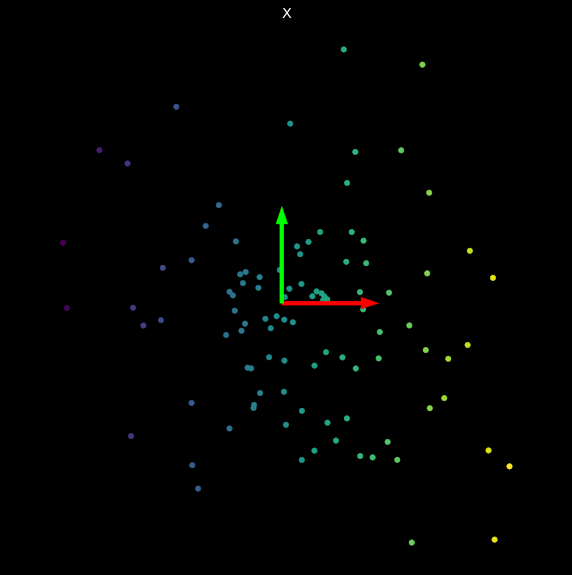

In [246]:
# Data before passing through network
show_scatterplot(X, colors, title='X')
OI = torch.cat((torch.zeros(2, 2), torch.eye(2)))
plot_bases(OI)

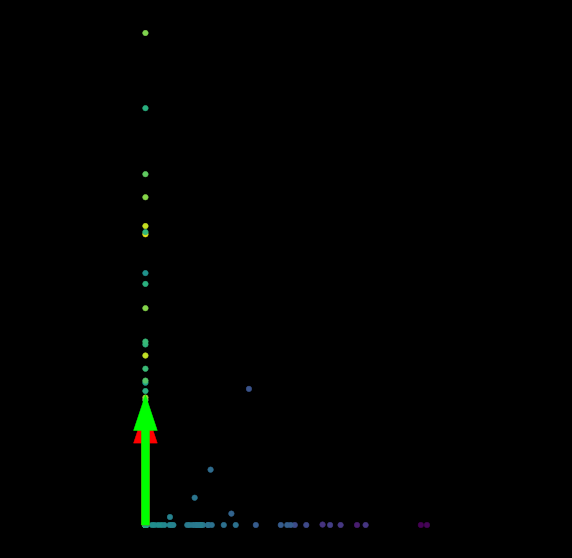

In [247]:
# Data after passing through network
with torch.no_grad():
    Y = linear_fc_relu(X)
    show_scatterplot(Y, colors)
    OI = torch.cat((torch.zeros(2, 2), torch.eye(2)))
    plot_bases(linear_fc_relu(OI))

In [252]:
torch.cat((torch.zeros(2, 2), torch.eye(2)))

tensor([[0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 1.]])

## 3.2. Sigmoid
The sigmoid function is another popular choice for a non-linear activation function which maps its input to values in the interval $(0,1)$. It is formally defined as:

$$\sigma(x) = \frac{1}{1+ exp[-x]}$$

Define a new neural network `linear_fc_sigmoid` which is the same architecture as in part `3.1.` but with a sigmoid unit instead of ReLU. 

Using the same $X$ as in part `3.1`, visualize the output of passing `X` through the neural network `linear_fc_sigmoid`.

In [248]:
# create 1-layer neural networks with Sigmoid activation
linear_fc_sigmoid = nn.Sequential(
                    nn.Linear(2, 2, bias=False),
                    nn.Sigmoid()
)
linear_fc_sigmoid

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=False)
  (1): Sigmoid()
)

In [249]:
# Visualize: TODO

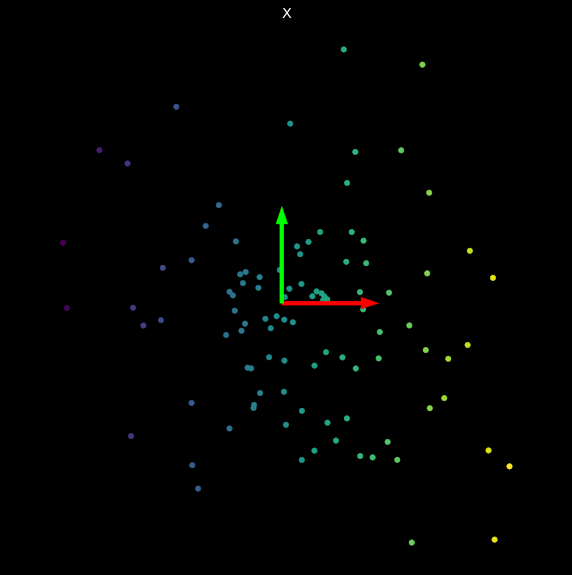

In [250]:
# Data before passing through network
show_scatterplot(X, colors, title='X')
OI = torch.cat((torch.zeros(2, 2), torch.eye(2)))
plot_bases(OI)

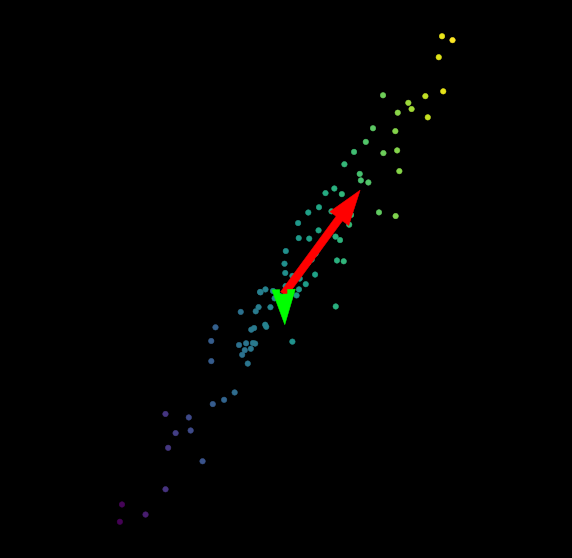

In [253]:
# Data after passing through network
with torch.no_grad():
    Y = linear_fc_sigmoid(X)
    show_scatterplot(Y, colors)
    OI = torch.cat((torch.zeros(2, 2), torch.eye(2)))
    plot_bases(linear_fc_sigmoid(OI), width=0.01)